In [1]:
# Mount YOUR google drive. You'll need to "Add shortcut to Drive" for our shared folder for it to show up here.
# Use the URL shown below in the output to authorize this Colab session to access you GDrive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

# Modify this according to the path in your computer
main_dir = '/content/drive/MyDrive/Research/2022_FloodsEPA/Results/'
data_dir = '/content/drive/MyDrive/Research/2022_FloodsEPA/Results/2020_20/' # <-- change this to reflect the pathing in your machine

Mounted at /content/drive/


In [2]:
# Import needed packages
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats as sts
from numpy.random import default_rng
from plotnine import *
import time
import pandas as pd

! pip install geopandas
! pip install geopy
! pip install -U plotly
! pip install cpi

import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance
from shapely.geometry import Point, Polygon
import plotly.express as px

rng = default_rng(13)
theAMI = 96349
vir1 = '#440154FF'
vir2 = '#3B528BFF'
vir3 = '#21908CFF'
vir4 = '#5DC863FF'
vir5 = '#FED725FF'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 31.0 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 35.4 MB/s eta 0:00:00


In [3]:
df_blds = pd.read_csv(main_dir + 'Buildings.txt',header=0)
df_blds['MortgageEnd'] = df_blds['Mortgage_Date'] + df_blds['Mortgage_Maturity']
df_blds['IncomeTag'] = df_blds['OwnerIncomeToday'].apply(lambda x: 'Very low' if x < 0.5 * theAMI else ('Low' if x < 0.8 * theAMI else ('Moderate' if x < 1.2 * theAMI else 'High')))
df_blds['MortgageTag'] = df_blds['MortgageEnd'].apply(lambda x: 'None' if x - 2020 <= 0  else ('<10' if x -2020 < 10  else ('<20' if x -2020 < 20 else '>20')))
df_blds['Equity'] = np.minimum((2022 - df_blds['Mortgage_Date']) / df_blds['Mortgage_Maturity'],1) * df_blds['HomeValue']
df_blds.head(2)

,Latitude,Longitude,Mortgage_Date,Mortgage_Maturity,HomeValue,OwnerIncomeToday,MortgageEnd,IncomeTag,MortgageTag,Equity
0,37.474263,-122.153298,2008,30.0,377565.570382,175012.968839,2038.0,High,<20,176197.266178
1,37.474234,-122.153097,2012,30.0,223821.548847,39760.901335,2042.0,Very low,>20,74607.182949


## Losses

### Real estate

In [5]:
df_realestate = pd.read_csv(data_dir + 'RealEstate.csv',header=None)
df_realestate.columns = ['S'+str(i) for i in range(df_realestate.shape[1])]
df_realestate = df_realestate.loc[:,'S0':'S999']

In [8]:
print('count:',np.nanmedian(df_realestate.replace(0,np.nan).count()))
print('median:',np.nanmedian(df_realestate.replace(0,np.nan).median(axis=0)))
print('mean:',np.nanmean(df_realestate.replace(0,np.nan).median(axis=0)))

count: 116.5
median: 23732.3309260005
mean: 29118.15430317985


In [7]:
116*43000

4988000

### Contents

In [4]:
df_contents = pd.read_csv(data_dir + 'Contents.csv',header=None)
df_contents.columns = ['S'+str(i) for i in range(df_contents.shape[1])]
df_contents.head(3)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S990,S991,S992,S993,S994,S995,S996,S997,S998,S999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_dmgs = df_realestate #+ df_contents
df_dmgs.head(3)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S990,S991,S992,S993,S994,S995,S996,S997,S998,S999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Insurance

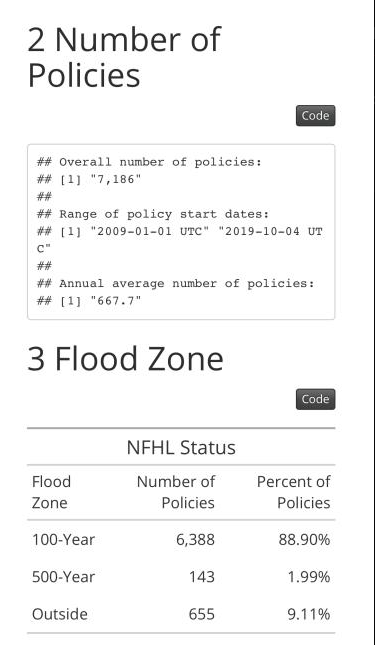

In [ ]:
def getInsuranceAmount(df_ins):
    a_deductibles = [500,1000,1250,1500,2000,3000,4000,5000,10000]
    p_deductibles = [0.89,12.09,6.69,0.06,28.53,1.92,1.35,45.45,3.02]
    p_deductibles = [i/sum(p_deductibles) for i in p_deductibles]


    for c in df_ins.columns:
        m = rng.choice(a=[1,0],p=[668/4265,1-668/4265],size=len(df_ins.index),replace=True)
        deductibles = rng.choice(a=a_deductibles,p=p_deductibles,size=len(df_ins.index),replace=True)
        df_ins[c] = np.minimum(np.maximum((df_dmgs[c] - deductibles) * m,0),250000)

    return df_ins

df_ins = getInsuranceAmount(df_dmgs.copy())
df_ins

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S990,S991,S992,S993,S994,S995,S996,S997,S998,S999
0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
2,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
3,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
4261,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
4262,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
4263,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0


## SBA

In [ ]:
def getSBALoan(PDD,income,equity,loss,balance):

    if PDD == False:
        sba_min = 14000.0
    else:
        sba_min = 25000.0

    sba_loan_maturity = 30
    sba_gdsr = 0.3
    sba_cap = 200000.0

    # Calculate the maximum loan amount
    # We use the mortgage equation to calculate P, the loan amount
    # M = P * r * (1 + r)**n / ((1+r)**n - 1)
    r = 0.04 / 12 # monthly interest rate at the last year in the dataframe
    n = sba_loan_maturity * 12 # maturity [months]
    P = 0.3 * (income/12) * ((1+r)**n - 1) / (r * (1 + r)**n)
    max_loan = max(sba_min,min(P,max(equity - loss,0)))
    sba_amt = min(balance,max_loan,sba_cap)

    return sba_amt

## Bank

In [ ]:
def getBankLoan(income,equity,loss,balance):

    bank_loan_maturity = 30.0
    bank_gdsr = 0.3
    bank_cap = 200000
    bank_min = 0

    # Calculate the maximum loan amount
    # We use the mortgage equation to calculate P, the loan amount
    # M = P * r * (1 + r)**n / ((1+r)**n - 1)
    r = 0.08 / 12 # monthly interest rate at the last year in the dataframe
    n = bank_loan_maturity * 12 # maturity [months]
    P = 0.3 * (income/12) * ((1+r)**n - 1) / (r * (1 + r)**n)
    max_loan = max(bank_min,min(P,max(equity - loss,0)))
    bank_amt = min(balance,max_loan,bank_cap)

    return bank_amt

# No Major Disaster Declaration

## SBA

In [ ]:
df_SBA = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999'])

for i in range(len(df_SBA.index)):
    income = df_blds.loc[i,'OwnerIncomeToday']
    for j in range(len(df_SBA.columns)):
        loss = df_dmgs.iloc[i,j]
        balance = UHN.iloc[i,j]
        equity = df_blds.loc[i,'Equity']
        if balance > 0 and equity > 0:
            df_SBA.iloc[i,j] = getSBALoan(False,income,equity,loss,balance)

## Bank

In [ ]:
df_bank = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999'])

for i in range(len(df_bank.index)):
    income = df_blds.loc[i,'OwnerIncomeToday']
    for j in range(len(df_bank.columns)):
        loss = df_dmgs.iloc[i,j]
        balance = UHN.iloc[i,j]
        equity = df_blds.loc[i,'Equity'] - df_SBA.iloc[i,j]

        if balance > 0 and equity > 0:
            df_bank.iloc[i,j] = getBankLoan(income,equity,loss,balance)

## Financing

In [ ]:
df_Financing_ND = pd.DataFrame()
df_Financing_ND['Loss'] = df_dmgs.replace(0,0).sum(axis=0)
df_Financing_ND['UHN'] = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).sum(axis=0)
df_Financing_ND['Loans'] = df_SBA.loc[:,'S0':'S999'].add(df_bank.loc[:,'S0':'S999']).sum(axis=0)

In [ ]:
df_summary_ND = pd.DataFrame()
df_summary_ND['Tag'] = df_blds['IncomeTag']
df_summary_ND['Loss'] = df_dmgs['S0']
df_summary_ND['Insurance'] = df_ins['S0']
df_summary_ND['FEMA'] = 0
df_summary_ND['SBA'] = df_SBA['S0']
df_summary_ND['SSGP'] = 0
df_summary_ND['Bank'] = df_bank['S0']
df_summary_ND['CDBGDR'] = 0
df_summary_ND['Unmet'] = df_dmgs['S0'].subtract(df_ins['S0']).subtract(df_SBA['S0']).subtract(df_bank['S0'])

## Unmet needs

In [ ]:
r1 = 0.08/12
r2 = 0.02/12
m = 30*12
df_UHN_ND =  df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).multiply(12 * (r1*(r1+1)**m)/((r1+1)**m - 1)) +\
            df_SBA.loc[:,'S0':'S999'].multiply(12 * (r2*(r2+1)**m)/((r2+1)**m - 1)) +\
            df_bank.loc[:,'S0':'S999'].multiply(12 * (r1*(r1+1)**m)/((r1+1)**m - 1))

df_UHN_ND = df_UHN_ND.clip(lower=0)



---



# Major Disaster Declaration

In [ ]:
filename = '100_5_2050_Disaster_FinancingModel/'

## FEMA

In [ ]:
def getFEMAApproval(FVL,income,insurance):

    if FVL < 5000:

        if income == 'Very low' and insurance == False:
            return 0.527
        elif income == 'Very low' and insurance == True:
            return 0.294
        elif income == 'Low' and insurance == False:
            return 0.523
        elif income == 'Low' and insurance == True:
            return 0.290
        elif income == 'Moderate' and insurance == False:
            return 0.519
        elif income == 'Moderate' and insurance == True:
            return 0.297
        elif income == 'High' and insurance == False:
            return 0.518
        elif income == 'High' and insurance == True:
            return 0.303

    else:
        if income == 'Very low' and insurance == False:
            return 0.838 - FVL * 3.3*1/np.power(10,6)
        elif income == 'Very low' and insurance == True:
            return 0.577 - FVL * 2.8*1/np.power(10,6)
        elif income == 'Low' and insurance == False:
            return 0.829 - FVL * 3.3*1/np.power(10,6)
        elif income == 'Low' and insurance == True:
            return 0.556 - FVL * 4.2*1/np.power(10,6)
        elif income == 'Moderate' and insurance == False:
            return 0.799 - FVL * 1.9*1/np.power(10,6)
        elif income == 'Moderate' and insurance == True:
            return 0.541 - FVL * 3.8*1/np.power(10,6)
        elif income == 'High' and insurance == False:
            return 0.756 - FVL * 7.9*1/np.power(10,6)
        elif income == 'High' and insurance == True:
            return 0.481 - FVL * 3.9*1/np.power(10,6)


def getFEMAAmount(FVL,income,insurance):
    if income == 'High' and insurance == True:
        return FVL**2 * -7.72*1/np.power(10,6) + 0.786 * FVL + 10385
    elif income != 'High' and insurance == True:
        return FVL**2 * -8.41*1/np.power(10,6) + 0.877 * FVL + 8335
    elif insurance == False:
        return FVL**2 * -1.47*1/np.power(10,5) + 1.223 * FVL + 6201

In [ ]:
df_FEMA = df_dmgs.clip(upper=0).copy()


UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999'])
UHN = UHN.clip(lower=0)

for j in range(UHN.shape[1]):
    fema = []
    for i in range(UHN.shape[0]):
        income = df_blds.loc[i,'IncomeTag']

        FVL = np.minimum(df_dmgs.iloc[i,j],40000)
        insurance = True if df_ins.iloc[i,j] > 0 else False

        fema_amt = 0
        if getFEMAApproval(FVL,income,insurance) > rng.random():
            fema_amt = np.minimum(getFEMAAmount(FVL,income,insurance),UHN.iloc[i,j])
        fema.append(fema_amt)


    df_FEMA[df_FEMA.columns[j]] = fema

## SBA

In [ ]:
df_SBA = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999'])
UHN = UHN.clip(lower=0)

for i in range(len(df_SBA.index)):
    income = df_blds.loc[i,'OwnerIncomeToday']
    for j in range(len(df_SBA.columns)):
        loss = df_dmgs.iloc[i,j]
        balance = UHN.iloc[i,j]
        equity = df_blds.loc[i,'Equity']
        if balance > 0 and equity > 0:
            df_SBA.iloc[i,j] = getSBALoan(True,income,equity,loss,balance)

## SSGP

In [ ]:
df_SSGP = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999'])
UHN = UHN.clip(lower=0)

for i in range(len(df_SSGP.index)):
    for j in range(len(df_SSGP.columns)):
        fema_amt = df_FEMA.iloc[i,j]
        sba_amt = df_SBA.iloc[i,j]
        if fema_amt > 0:
            df_SSGP.iloc[i,j] = np.maximum(0,np.minimum(UHN.iloc[i,j],10000))

## Bank

In [ ]:
df_bank = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_SSGP.loc[:,'S0':'S999'])

for i in range(len(df_bank.index)):
    income = df_blds.loc[i,'OwnerIncomeToday']
    for j in range(len(df_bank.columns)):
        loss = df_dmgs.iloc[i,j]
        balance = UHN.iloc[i,j]
        equity = df_blds.loc[i,'Equity'] - df_SBA.iloc[i,j]

        if balance > 0 and equity > 0:
            df_bank.iloc[i,j] = getBankLoan(income,equity,loss,balance)

## Financing

In [ ]:
df_Financing_DD = pd.DataFrame()
df_Financing_DD['Loss'] = df_dmgs.replace(0,0).sum(axis=0)
df_Financing_DD['UHN'] = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SSGP.loc[:,'S0':'S999'])\
                        .subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).sum(axis=0)
df_Financing_DD['Loans'] = df_SBA.loc[:,'S0':'S999'].add(df_bank.loc[:,'S0':'S999']).sum(axis=0)

In [ ]:
df_summary_DD = pd.DataFrame()
df_summary_DD['Tag'] = df_blds['IncomeTag']
df_summary_DD['Loss'] = df_dmgs['S0']
df_summary_DD['Insurance'] = df_ins['S0']
df_summary_DD['FEMA'] = df_FEMA['S0']
df_summary_DD['SBA'] = df_SBA['S0']
df_summary_DD['SSGP'] = df_SSGP['S0']
df_summary_DD['Bank'] = df_bank['S0']
df_summary_DD['CDBGDR'] = 0
df_summary_DD['Unmet'] = df_dmgs['S0'].subtract(df_ins['S0']).subtract(df_FEMA['S0']).subtract(df_SSGP['S0'])\
                        .subtract(df_SBA['S0']).subtract(df_bank['S0'])

## Unmet needs

In [ ]:
r1 = 0.08/12
r2 = 0.02/12
m = 30*12
df_UHN_DD = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999'])\
            .subtract(df_SSGP.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).multiply(12 * (r1*(r1+1)**m)/((r1+1)**m - 1)) +\
            df_SBA.loc[:,'S0':'S999'].multiply(12 * (r2*(r2+1)**m)/((r2+1)**m - 1)) +\
            df_bank.loc[:,'S0':'S999'].multiply(12 * (r1*(r1+1)**m)/((r1+1)**m - 1))

df_UHN_DD = df_UHN_DD.clip(lower=0)



---

---





# Major Disaster Declaration + CDBGDR

## CDBGDR

In [ ]:
df_CDBG = df_dmgs.clip(upper=0).copy()
UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999'])\
            .subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_SSGP.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999'])
UHN = UHN.clip(lower=0)

for j in range(UHN.shape[1]):
    v = []
    for i in range(UHN.shape[0]):
        if df_blds.loc[i,'IncomeTag'] not in ['High','Moderate']:
            v.append(np.minimum(150000,UHN.iloc[i,j]))
        else:
            v.append(0)

    df_CDBG[df_CDBG.columns[j]] = v

## Financing

In [ ]:
df_Financing_CD = pd.DataFrame()
df_Financing_CD['Loss'] = df_dmgs.replace(0,0).sum(axis=0)
df_Financing_CD['UHN'] = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SSGP.loc[:,'S0':'S999'])\
                        .subtract(df_CDBG.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).sum(axis=0)
df_Financing_CD['Loans'] = df_SBA.loc[:,'S0':'S999'].add(df_bank.loc[:,'S0':'S999']).sum(axis=0)

In [ ]:
df_summary_CD = pd.DataFrame()
df_summary_CD['Tag'] = df_blds['IncomeTag']
df_summary_CD['Loss'] = df_dmgs['S0']
df_summary_CD['Insurance'] = df_ins['S0']
df_summary_CD['FEMA'] = df_FEMA['S0']
df_summary_CD['SBA'] = df_SBA['S0']
df_summary_CD['SSGP'] = df_SSGP['S0']
df_summary_CD['Bank'] = df_bank['S0']
df_summary_CD['CDBGDR'] = df_CDBG['S0']
df_summary_CD['Unmet'] = df_dmgs['S0'].subtract(df_ins['S0']).subtract(df_FEMA['S0']).subtract(df_SSGP['S0'])\
                        .subtract(df_CDBG['S0']).subtract(df_SBA['S0']).subtract(df_bank['S0'])

## Unmet needs

In [ ]:
r1 = 0.08/12
r2 = 0.02/12
m = 30*12
df_UHN_CD = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999'])\
            .subtract(df_SSGP.loc[:,'S0':'S999']).subtract(df_CDBG.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).multiply(12 * (r1*(r1+1)**m)/((r1+1)**m - 1)) +\
            df_SBA.loc[:,'S0':'S999'].multiply(12 * (r2*(r2+1)**m)/((r2+1)**m - 1)) +\
            df_bank.loc[:,'S0':'S999'].multiply(12 * (r1*(r1+1)**m)/((r1+1)**m - 1))

df_UHN_CD = df_UHN_CD.clip(lower=0)



---



---




# Well-being Loss

In [ ]:
def getLossOfWellBeing(income,mtg_amt,mtg_mat,loan_amt,loan_mat):
    # Adapted from Markhvida et al: Quantification of disaster impacts through household well-being losses

    # Inputs
    AMI = theAMI
    eta = 1.5 # elasticity of marginal utility of consumption
    theDiscountRate = 0.1
    theMortgageYears = int(np.round(mtg_mat)) # duration remaining on mortgage
    mtginstallment = mtg_amt
    theLoanMaturity = int(np.round(loan_mat)) # loan maturity
    loanInstallment = loan_amt # annual expenditure with loan payment

    # Consumption
    theC0a = income - mtginstallment # consumption pre-disaster
    theC0b = income  # consumption pre-disaster, if no mortgage
    theC1 = income - mtginstallment - loanInstallment # consumption post disaster, during mortgage
    theC2 = income - loanInstallment # consumption post disaster, post mortgage
    theAMIC = 0.7 * AMI

                          # during mortgage +\ after mortgage
    theLossOfWellBeing = (theC0a**(1-eta) - theC1**(1-eta)) * np.sum([np.exp(-0.1) for i in range(theMortgageYears)]) +\
                        (theC0b**(1-eta) - theC2**(1-eta)) * np.sum([np.exp(-0.1) for i in range(theMortgageYears,theLoanMaturity,1)])

    theLossOfWellBeing /= (1 - eta)

    # The equivalent consumption change represents the dollar amount by which a household earning the mean Area income would have to decrease its consumption
    # to experience the same well-being decrease as the considered household
    theEquivalentLossInConsumption = theAMIC - np.power(-(1 - eta) * theLossOfWellBeing/np.sum([np.exp(-0.1) for i in range(30)]) + theAMIC**(1-eta),1/(1-eta))

    return theEquivalentLossInConsumption

In [ ]:
df_ND = pd.merge(df_UHN_ND,df_blds[['OwnerIncomeToday','MortgageEnd']], right_index=True, left_index=True)
df_ND['MortgageEnd'] = df_ND['MortgageEnd'].apply(lambda x: np.maximum(x-2020,0))

r = 0.08/12
m = 30*12
for j in range(df_ND.shape[1]-2):
    v = []
    for i in range(df_ND.shape[0]):
        if df_ND.loc[i,'S'+str(j)] > 0:
            income = df_ND.loc[i,'OwnerIncomeToday']
            mtg_amt = 0.3 * income
            mtg_mat = int(df_ND.loc[i,'MortgageEnd'])
            loan_amt = df_ND.loc[i,'S'+str(j)]# * 12 * (r*(r+1)**m)/((r+1)**m - 1)
            loan_mat = 30
            v.append(getLossOfWellBeing(income,mtg_amt,mtg_mat,loan_amt,loan_mat))
        else:
            v.append(np.nan)

    print(j)
    df_ND['S'+str(j)] = v

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
df_DD = pd.merge(df_UHN_DD,df_blds[['OwnerIncomeToday','MortgageEnd']], right_index=True, left_index=True)
df_DD['MortgageEnd'] = df_DD['MortgageEnd'].apply(lambda x: np.maximum(x-2020,0))

r = 0.08/12
m = 12 * 30
for j in range(df_DD.shape[1]-2):
    v = []
    for i in range(df_DD.shape[0]):
        if df_DD.loc[i,'S'+str(j)] > 0:
            income = df_DD.loc[i,'OwnerIncomeToday']
            mtg_amt = 0.3 * income
            mtg_mat = int(df_DD.loc[i,'MortgageEnd'])
            loan_amt = df_DD.loc[i,'S'+str(j)]# * 12 * (r*(r+1)**m)/((r+1)**m - 1)
            loan_mat = 30
            v.append(getLossOfWellBeing(income,mtg_amt,mtg_mat,loan_amt,loan_mat))
        else:
            v.append(np.nan)

    print(j)
    df_DD['S'+str(j)] = v

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
df_CD = pd.merge(df_UHN_CD,df_blds[['OwnerIncomeToday','MortgageEnd']], right_index=True, left_index=True)
df_CD['MortgageEnd'] = df_CD['MortgageEnd'].apply(lambda x: np.maximum(x-2020,0))

r = 0.08/12
m = 12 * 30
for j in range(df_CD.shape[1]-2):
    v = []
    for i in range(df_CD.shape[0]):
        if df_CD.loc[i,'S'+str(j)] > 0:
            income = df_CD.loc[i,'OwnerIncomeToday']
            mtg_amt = 0.3 * income
            mtg_mat = int(df_CD.loc[i,'MortgageEnd'])
            loan_amt = df_CD.loc[i,'S'+str(j)]# * 12 * (r*(r+1)**m)/((r+1)**m - 1)
            loan_mat = 30
            v.append(getLossOfWellBeing(income,mtg_amt,mtg_mat,loan_amt,loan_mat))
        else:
            v.append(np.nan)

    print(j)
    df_CD['S'+str(j)] = v

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
def getConsumptionReduction(df):
    df['IncomeTag'] = df_blds['IncomeTag']
    vl = []
    l = []
    m = []
    h = []
    for i in range(df.shape[1]-4):
        vl.append(df[df['IncomeTag'] == 'Very low']['S'+str(i)].mean(skipna=True,axis=0))
        l.append(df[df['IncomeTag'] == 'Low']['S'+str(i)].mean(skipna=True,axis=0))
        m.append(df[df['IncomeTag'] == 'Moderate']['S'+str(i)].mean(skipna=True,axis=0))
        h.append(df[df['IncomeTag'] == 'High']['S'+str(i)].mean(skipna=True,axis=0))

    df_return = pd.DataFrame()
    df_return['Very low'] = vl
    df_return['Low'] = l
    df_return['Moderate'] = m
    df_return['High'] = h

    return df_return

In [ ]:
df1 = getConsumptionReduction(df_ND)
df1['Tag'] = 'No'

df2 = getConsumptionReduction(df_DD)
df2['Tag'] = 'Yes'

df3 = getConsumptionReduction(df_CD)
df3['Tag'] = 'Yes + CDBGDR'

df = pd.concat([df1,df2,df3],ignore_index=True)

df_long = pd.melt(df,id_vars='Tag')

df_long['variable'] = pd.Categorical(df_long['variable'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)
df_long['Tag'] = pd.Categorical(df_long['Tag'] ,
                      categories=['No','Yes','Yes + CDBGDR'],
                      ordered=True)

<ipython-input-32-3b934a0fd3f4>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<ipython-input-32-3b934a0fd3f4>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<ipython-input-32-3b934a0fd3f4>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 1569 rows containing non-finite values.


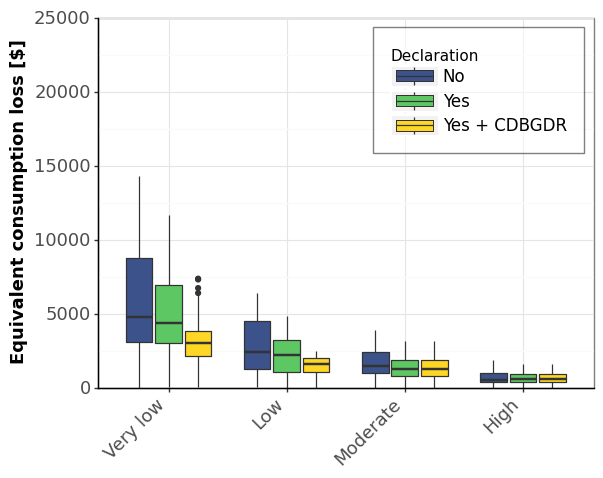

<ggplot: (8388701190532)>

In [ ]:
plot_base = ggplot(df_long,aes(x='variable',y='value',fill='Tag')) + geom_boxplot()

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.72,0.73),
        legend_key=element_rect(color = 'white'),
        legend_key_width=35,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(fill='Declaration')+\
        scale_fill_manual(values=[vir2,vir4,vir5]) +\
        scale_y_continuous(name = 'Equivalent consumption loss [$]',expand=[0,0],limits=[0,25000]) +\
        scale_x_discrete(name = '')

#ggsave(plot_clean, filename = 'Fig_2050_100_5.pdf', path = data_dir)
plot_clean

In [ ]:
df_ND = df_ND.replace(np.nan,0)
df_ND['Mean'] = df_ND.loc[:,'S0':'S999'].mean(axis=1)

df_DD = df_DD.replace(np.nan,0)
df_DD['Mean'] = df_DD.loc[:,'S0':'S999'].mean(axis=1)

df = pd.DataFrame()
df['Tag'] = df_blds['IncomeTag']
df['Loss'] = df_dmgs.replace(0,np.nan).count(axis=1)
df['Income'] = df_blds['OwnerIncomeToday']
df['Latitude'] = df_blds['Latitude']
df['Longitude'] = df_blds['Longitude']
df['DeltaW'] = df_ND['Mean'] - df_DD['Mean']
df['DeltaW2'] = df['DeltaW'].apply(lambda x: 1 if x > 0 else 0)
df['Flooded'] = df['Loss'].divide(1000)

df['Tag'] = pd.Categorical(df['Tag'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)

df_plt = df
var = 'DeltaW'
df_plt = df_plt[(df_plt[var]>np.percentile(df_plt[var],5)) & (df_plt[var]<np.percentile(df_plt[var],95))]
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        color="DeltaW",
                        center={"lat": 37.4667, "lon": -122.1364},
                        mapbox_style="carto-positron",
                        color_continuous_scale='Viridis',
                        #hover_data = ['Units','Tenure'],
                        zoom=13,
                        height=700,
                        width=800
                      )
fig.show()

array([[<Axes: title={'center': 'Flooded'}>]], dtype=object)

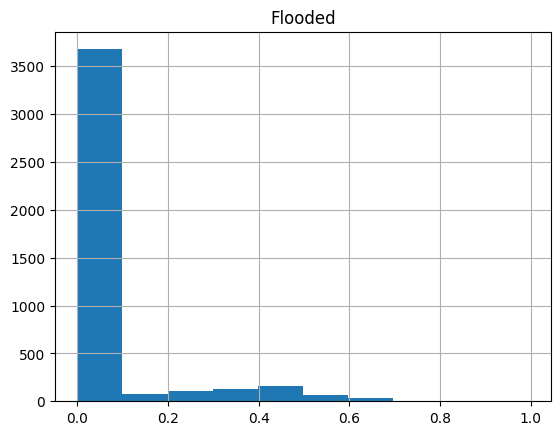

In [ ]:
df.hist('Flooded')

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:411: PlotnineWarning:

geom_point : Removed 3604 rows containing missing values.

/usr/local/lib/python3.10/dist-packages/plotnine/guides/guides.py:187: PlotnineWarning:

Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it



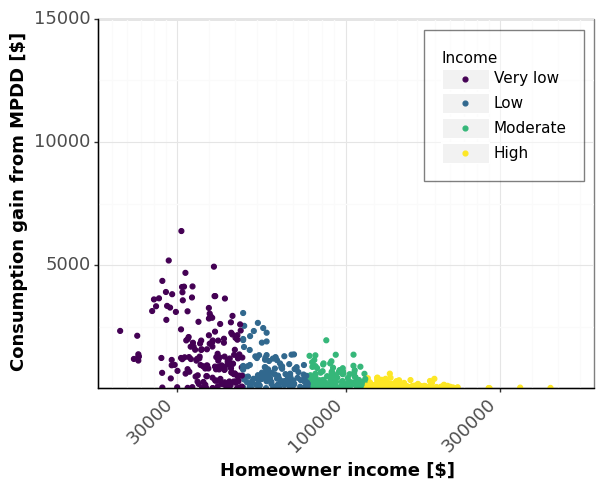

<ggplot: (8388700407568)>

In [ ]:
df = df[df['Income']<500000].copy()
#df['Income'] = pd.cut(df['Income'],bins=[0,25000,50000,75000,100000,200000,1000000])
plot_base = ggplot(df,aes(x='Income',y='DeltaW',color='Tag')) + geom_point()

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.76,0.7),
        legend_key=element_rect(color = 'white'),
        legend_key_width=35,
        legend_text=element_text(size=11),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(color='Income')+\
        scale_fill_manual(values=['black',vir2,vir4,vir5]) +\
        scale_y_continuous(name = 'Consumption gain from MPDD [$]',expand=[0,0],limits=[1,15000]) +\
        scale_x_log10(name = 'Homeowner income [$]')

plot_clean

# Financing

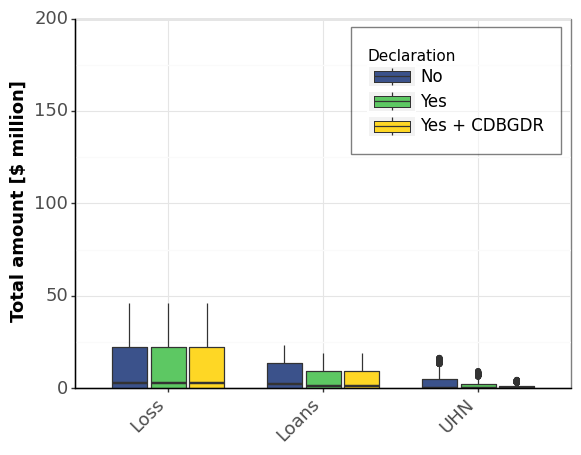

<ggplot: (8388700390235)>

In [ ]:
df_Financing_ND['Tag'] = 'No'
df_Financing_DD['Tag'] = 'Yes'
df_Financing_CD['Tag'] = 'Yes + CDBGDR'

df_Financing = pd.concat([df_Financing_ND,df_Financing_DD,df_Financing_CD],ignore_index=True)

df_Financing_long = pd.melt(df_Financing,id_vars='Tag')

df_Financing_long['value'] = df_Financing_long['value'].divide(10**6)

df_Financing_long['variable'] = pd.Categorical(df_Financing_long['variable'] ,
                      categories=['Loss','Loans','UHN'],
                      ordered=True)

plot_base = ggplot(df_Financing_long,aes(x='variable',y='value',fill='Tag')) + geom_boxplot()

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.72,0.73),
        legend_key=element_rect(color = 'white'),
        legend_key_width=35,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(fill='Declaration')+\
        scale_fill_manual(values=[vir2,vir4,vir5]) +\
        scale_y_continuous(name = 'Total amount [$ million]',expand=[0,0],limits=[0,200]) +\
        scale_x_discrete(name = '')
#ggsave(plot_clean, filename = 'Fig_2050_100_5_Financing.pdf', path = data_dir)
plot_clean

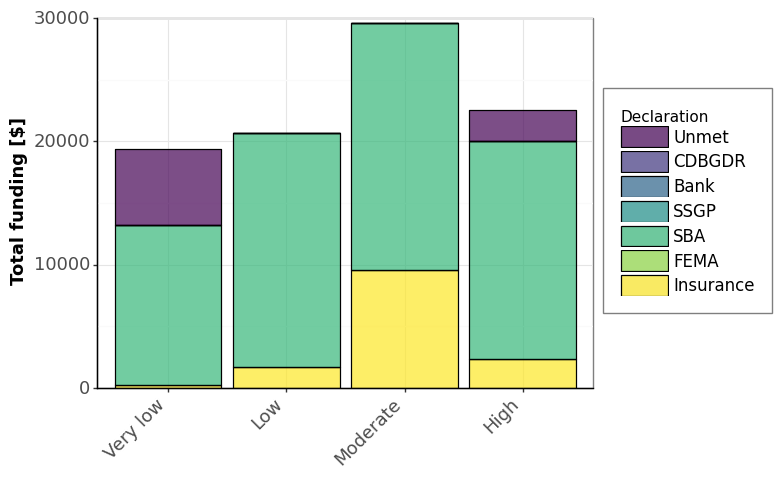

<ggplot: (8388701190544)>

In [ ]:
df_summary = df_summary_ND.copy()

df_summary = df_summary[df_summary['Loss']>0].reset_index(drop=True)
# df_summary['Insurance'] = df_summary['Insurance'] / df_summary['Loss']
# df_summary['FEMA'] = df_summary['FEMA'] / df_summary['Loss']
# df_summary['SBA'] = df_summary['SBA'] / df_summary['Loss']
# df_summary['SSGP'] = df_summary['SSGP'] / df_summary['Loss']
# df_summary['Bank'] = df_summary['Bank'] / df_summary['Loss']
# df_summary['CDBGDR'] = df_summary['CDBGDR'] / df_summary['Loss']
# df_summary['Unmet'] = df_summary['Unmet'] / df_summary['Loss']
df_summary = df_summary.drop('Loss',axis=1)

df_bars = df_summary.groupby(by='Tag').mean().reset_index(drop=False)

df_bars_long = pd.melt(df_bars,id_vars='Tag')

df_bars_long['Tag'] = pd.Categorical(df_bars_long['Tag'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)

df_bars_long['variable'] = pd.Categorical(df_bars_long['variable'] ,
                      categories=['Unmet','CDBGDR','Bank','SSGP','SBA','FEMA','Insurance'],
                      ordered=True)


plot_base = ggplot(df_bars_long,aes(x='Tag',y='value',fill='variable')) + geom_col(position='stack',color='black',alpha=0.7)
plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        #legend_position = (0.72,0.73),
        legend_key=element_rect(color = 'white'),
        legend_key_width=35,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(fill='Declaration')+\
        scale_y_continuous(name = 'Total funding [$]',expand=[0,0],limits=[0,30000]) +\
        scale_x_discrete(name = '')

plot_clean

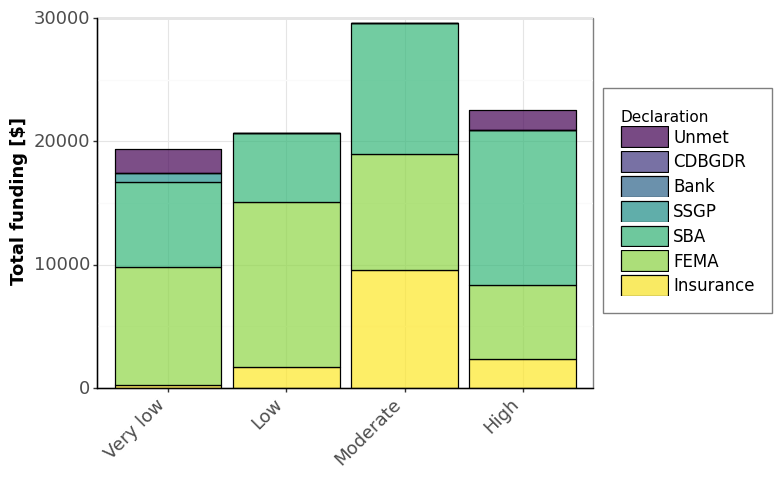

<ggplot: (8388698547258)>

In [ ]:
df_summary = df_summary_DD.copy()

df_summary = df_summary[df_summary['Loss']>0].reset_index(drop=True)
# df_summary['Insurance'] = df_summary['Insurance'] / df_summary['Loss']
# df_summary['FEMA'] = df_summary['FEMA'] / df_summary['Loss']
# df_summary['SBA'] = df_summary['SBA'] / df_summary['Loss']
# df_summary['SSGP'] = df_summary['SSGP'] / df_summary['Loss']
# df_summary['Bank'] = df_summary['Bank'] / df_summary['Loss']
# df_summary['CDBGDR'] = df_summary['CDBGDR'] / df_summary['Loss']
# df_summary['Unmet'] = df_summary['Unmet'] / df_summary['Loss']
df_summary = df_summary.drop('Loss',axis=1)

df_bars = df_summary.groupby(by='Tag').mean().reset_index(drop=False)

df_bars_long = pd.melt(df_bars,id_vars='Tag')

df_bars_long['Tag'] = pd.Categorical(df_bars_long['Tag'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)

df_bars_long['variable'] = pd.Categorical(df_bars_long['variable'] ,
                      categories=['Unmet','CDBGDR','Bank','SSGP','SBA','FEMA','Insurance'],
                      ordered=True)


plot_base = ggplot(df_bars_long,aes(x='Tag',y='value',fill='variable')) + geom_col(position='stack',color='black',alpha=0.7)
plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        #legend_position = (0.72,0.73),
        legend_key=element_rect(color = 'white'),
        legend_key_width=35,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(fill='Declaration')+\
        scale_y_continuous(name = 'Total funding [$]',expand=[0,0],limits=[0,30000]) +\
        scale_x_discrete(name = '')

plot_clean

In [ ]:
df_summary_CD

,Tag,Loss,Insurance,FEMA,SBA,SSGP,Bank,CDBGDR,Unmet
0,High,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Very low,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Low,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,High,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Moderate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4260,High,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
4261,Moderate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4262,Moderate,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
4263,Moderate,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0


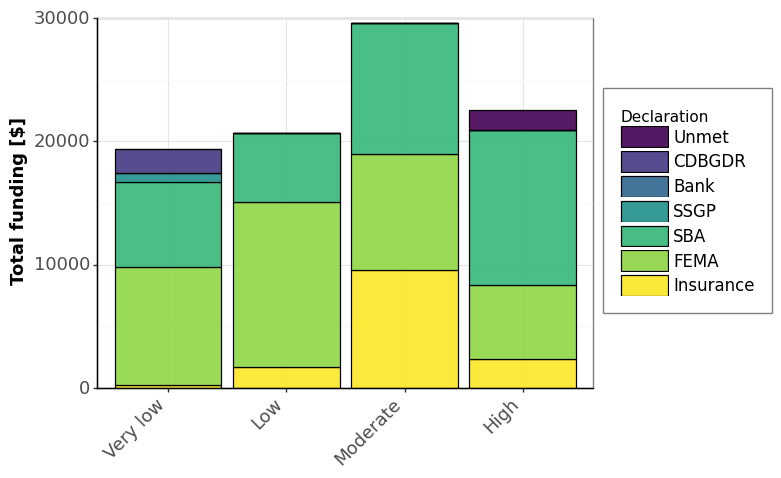

<ggplot: (8388698582998)>

In [ ]:
df_summary = df_summary_CD.copy()

df_summary = df_summary[df_summary['Loss']>0].reset_index(drop=True)
# df_summary['Insurance'] = df_summary['Insurance'] / df_summary['Loss']
# df_summary['FEMA'] = df_summary['FEMA'] / df_summary['Loss']
# df_summary['SBA'] = df_summary['SBA'] / df_summary['Loss']
# df_summary['SSGP'] = df_summary['SSGP'] / df_summary['Loss']
# df_summary['Bank'] = df_summary['Bank'] / df_summary['Loss']
# df_summary['CDBGDR'] = df_summary['CDBGDR'] / df_summary['Loss']
# df_summary['Unmet'] = df_summary['Unmet'] / df_summary['Loss']
df_summary = df_summary.drop('Loss',axis=1)

df_bars = df_summary.groupby(by='Tag').mean().reset_index(drop=False)

df_bars_long = pd.melt(df_bars,id_vars='Tag')

df_bars_long['Tag'] = pd.Categorical(df_bars_long['Tag'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)

df_bars_long['variable'] = pd.Categorical(df_bars_long['variable'] ,
                      categories=['Unmet','CDBGDR','Bank','SSGP','SBA','FEMA','Insurance'],
                      ordered=True)


plot_base = ggplot(df_bars_long,aes(x='Tag',y='value',fill='variable')) + geom_col(position='stack',color='black',alpha=0.9)
plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        #legend_position = (0.72,0.73),
        legend_key=element_rect(color = 'white'),
        legend_key_width=35,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(fill='Declaration')+\
        scale_y_continuous(name = 'Total funding [$]',expand=[0,0],limits=[0,30000]) +\
        scale_x_discrete(name = '')

plot_clean



---



---

